Problem 1

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import classification_report, mean_squared_error

data = pd.read_csv("strongdrink.txt")
data.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [2]:
#a
X = data[["alco","malic","tot_phen","color_int"]]
y = data["cultivar"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)
results = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000).fit(X_train, y_train)
print(results.intercept_)
print(results.coef_)

[-24.02761666  22.78073263   1.24688403]
[[ 1.70173445 -0.26578758  1.22410094  0.02250697]
 [-1.46629729 -0.33295147  0.66355615 -0.92268168]
 [-0.23543716  0.59873905 -1.88765709  0.90017471]]


In [3]:
pd.DataFrame({"j=1":np.append(results.intercept_[0],results.coef_[0]), "j=2":np.append(results.intercept_[1],results.coef_[1])},
               index=["b0","b1",'b2','b3','b4'])

,j=1,j=2
b0,-24.027617,22.780733
b1,1.701734,-1.466297
b2,-0.265788,-0.332951
b3,1.224101,0.663556
b4,0.022507,-0.922682


In [4]:
y_hat = results.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



As we can observe from the above report, the error rate of having j = 1 is 13%, while the error rates of j = 2 and j = 3 are both 0. Since the cultivar 3 has a higher recall score than cultivar 2, we can conclude cultivar 3 is the model best at predicting. 

In [5]:
data['cultivar'].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

So cultivar 2 has the most observations but it isn't the most accurately predicted category while cultivar 3 is.

In [6]:
print('MSE =', mean_squared_error(y_test, y_hat))

MSE = 0.045454545454545456


In [7]:
#b
from sklearn.model_selection import LeaveOneOut

X1 = X.values
y1 = y.values
y_test1 = np.zeros(X1.shape[0])
y_hat = np.zeros(X1.shape[0])
N_loo = X1.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X1)
MSE_vec = np.zeros(N_loo)

for train_index, test_index in loo.split(X1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    
    y_test1[test_index] = y_test
    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_hat1 = LogReg.predict(X_test)
    y_hat[test_index] = y_hat1
    
    if y_test == y_hat1:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1

In [8]:
print(classification_report(y_test1, y_hat))

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.92        59
         2.0       0.91      0.90      0.91        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



So the error rates of cultivar 1, 2, 3 are respectively 10%, 9%, 4%. The error rate of cultivar 1 gets smaller compared with the results from (a), while that of cultivar 2 and 3 become larger. 

In [9]:
MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('The MSE mean estimated by LOOCV is', MSE_loo)
print('The MSE standard error estimated by LOOCV is', MSE_loo_std)

The MSE mean estimated by LOOCV is 0.07954545454545454
The MSE standard error estimated by LOOCV is 0.2705882022679695


In [60]:
#c
from sklearn.model_selection import KFold

k = 4
kf = KFold(n_splits = k, random_state = 10, shuffle = True)
kf.get_n_splits(X1)

MSE_vec_kf = np.zeros(4)

y_test2 = np.array([])
ypred = np.array([])
k_ind = int(0)

for train_index, test_index in kf.split(X1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    
    results_1c = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    results_1c.fit(X_train, y_train)
    y_pred = results_1c.predict(X_test)
    
    MSE_vec_kf[k_ind] =(1 - (y_test == y_pred)).mean()
    y_test2 = np.append(y_test2, y_test)
    ypred = np.append(ypred, y_pred)
    
    k_ind += 1

print(classification_report(y_test2, ypred))

              precision    recall  f1-score   support

         1.0       0.87      0.93      0.90        59
         2.0       0.91      0.87      0.89        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



So the error rates of cultivar 1, 2, 3 are respectively 13%, 9%, 4%. The error rate of cultivar 1 is the same as that from (a) but smaller than that from (b). And the error rates of cultivar 2 and 3 are the same as those from (b), but larger than those from (a), respectively.

In [59]:
MSE_kf1 = MSE_vec_kf.mean()
MSE_kf_std1 = MSE_vec_kf.std()
print('MSE estimated by k-fold =', MSE_kf1)
print('MSE standard error estimated by k-fold =', MSE_kf_std1)

MSE estimated by k-fold = 0.09090909090909091
MSE standard error estimated by k-fold = 0.04821182598999188


Problem 2

In [38]:
#a
data2=pd.read_csv("CoolIndex.txt",names=["age","coolness"])

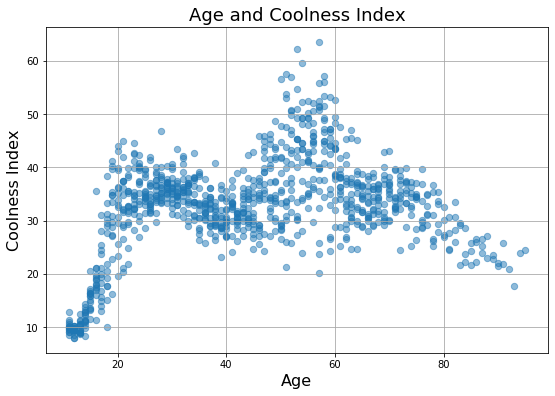

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.scatter(data2['age'], data2['coolness'], s=40, marker='o', alpha=0.5, label='Data')
ax.grid(b=True, which='major', color='0.65', linestyle='-')
ax.set_xlabel(r'Age', size=16)
ax.set_ylabel(r'Coolness Index', size=16)
ax.set_title(r'Age and Coolness Index', size=18)
plt.show()

In [19]:
#b
import statsmodels.api as sm

data2["bin1"]= np.where((data2.age >= 11) & (data2.age < 22), 1, 0)
data2["bin2"]= np.where((data2.age >= 22) & (data2.age < 40), 1, 0)
data2["bin3"]= np.where((data2.age >= 40) & (data2.age < 59), 1, 0)
data2["bin4"]= np.where((data2.age >= 59) & (data2.age < 77), 1, 0)
data2["bin5"]= np.where((data2.age >= 77) & (data2.age <= 95), 1, 0)

In [20]:
X3 = data2[["bin1","bin2","bin3","bin4","bin5"]]
results_2b = sm.OLS(data2.coolness, X3).fit()
print(results_2b.summary())

                            OLS Regression Results                            
Dep. Variable:               coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        21:48:12   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bin1          20.1025      0.562     35.746      0.0

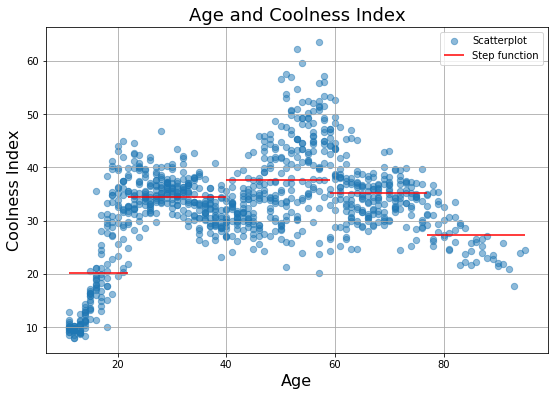

In [46]:
values = [results_2b.predict([1, 0, 0, 0, 0]), results_2b.predict([0, 1, 0, 0, 0]), results_2b.predict([0, 0, 1, 0, 0]),
          results_2b.predict([0, 0, 0, 1, 0]), results_2b.predict([0, 0, 0, 0, 1])]
          
plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.scatter(data2['age'],data2['coolness'], s=40, marker='o', alpha=0.5, label='Scatterplot')
x_min = np.array([11, 22, 40, 59, 77])
x_max = np.array([22, 40, 59, 77, 95])
ax.hlines(values, x_min, x_max, color='r', label= 'Step function')
ax.grid(b=True, which='major', color='0.65', linestyle='-')
ax.set_xlabel(r'Age', size=16)
ax.set_ylabel(r'Coolness Index', size=16)
ax.set_title(r'Age and Coolness Index', size=18)
ax.legend()
plt.show()

In [22]:
pd.DataFrame(values, index = ["beta1", "beta2", "beta3", "beta4", "beta5"], columns = ["value"])

,value
beta1,20.102457
beta2,34.475788
beta3,37.635105
beta4,35.225400
beta5,27.296378


We can see from the above dataframe, the predicted coolness of a 73-year-old from the stepwise function is 35.2254, since 73-year-old is in the fourth group.

In [39]:
#c
from scipy.interpolate import LSQUnivariateSpline

d2_group = data2.groupby('age').mean()
d2_group['age']=d2_group.index
d2_group.head()

,coolness,age
age,,
11.0,10.110237,11.0
12.0,9.365623,12.0
13.0,10.015882,13.0
14.0,11.747109,14.0
15.0,15.434739,15.0


In [41]:
knots = [22,40,59,77]
linear_spline = LSQUnivariateSpline(np.array(d2_group.age), np.array(d2_group.coolness), t = knots, k = 1)

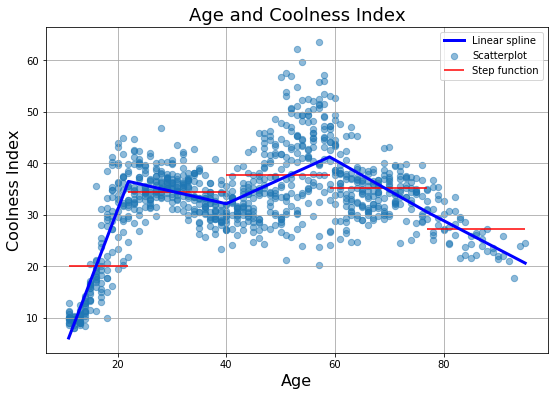

In [45]:
plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.scatter(data2['age'],data2['coolness'], s=40, marker='o', alpha=0.5, label='Scatterplot')
x_min = np.array([11, 22, 40, 59, 77])
x_max = np.array([22, 40, 59, 77, 95])
ax.hlines(values, x_min, x_max, color='r', label= 'Step function')
ax.plot(data2['age'], linear_spline(data2['age']), color='b', linewidth=3, label='Linear spline')
ax.grid(b=True, which='major', color='0.65', linestyle='-')
ax.set_xlabel(r'Age', size=16)
ax.set_ylabel(r'Coolness Index', size=16)
ax.set_title(r'Age and Coolness Index', size=18)
ax.legend()
plt.show()

In [48]:
print("The predicted coolness of 73-year-old from linear spline is", linear_spline(73))

The predicted coolness of 73-year-old from linear spline is 32.86784862349653


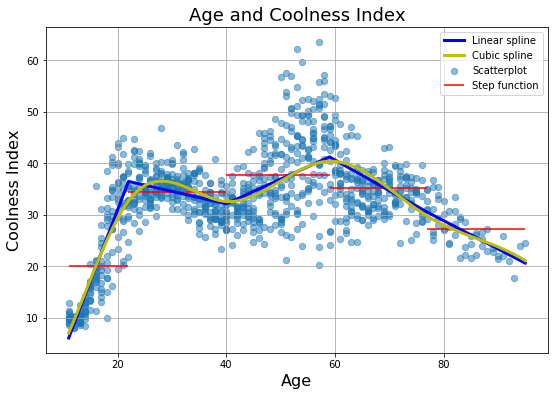

In [53]:
#d
cubic_spline = LSQUnivariateSpline(np.array(d2_group.age), np.array(d2_group.coolness), t=knots, k=3)

plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.scatter(data2['age'],data2['coolness'], s=40, marker='o', alpha=0.5, label='Scatterplot')
x_min = np.array([11, 22, 40, 59, 77])
x_max = np.array([22, 40, 59, 77, 95])
ax.hlines(values, x_min, x_max, color='r', label= 'Step function')
ax.plot(data2['age'], linear_spline(data2['age']), color='b', linewidth=3, label='Linear spline')
ax.plot(data2['age'], cubic_spline(data2['age']), color='y', linewidth=3, label='Cubic spline')
ax.grid(b=True, which='major', color='0.65', linestyle='-')
ax.set_xlabel(r'Age', size=16)
ax.set_ylabel(r'Coolness Index', size=16)
ax.set_title(r'Age and Coolness Index', size=18)
ax.legend()
plt.show()

In [54]:
print("The predicted coolness of 73-year-old from cubic spline is", cubic_spline(73))

The predicted coolness of 73-year-old from cubic spline is 32.642301066279764
